# FINAL PROJECT GROUP 1
# TOTAL ENERGIES RISK ANALYSIS

Introduction

Understanding the dynamics of financial time series is essential for evaluating market risk, especially for firms operating in highly cyclical and globally exposed sectors. In this report, we analyze the stock price behaviour of TotalEnergies SE (TTE), one of the world’s largest integrated energy companies. TotalEnergies operates across oil, natural gas, renewables, and electricity, making its market valuation sensitive to fluctuations in commodity prices, geopolitical developments, and global energy-transition policies. These characteristics create pronounced periods of market volatility, making TotalEnergies an instructive case for volatility modelling and risk assessment.

Following the project guidelines, the objective of this analysis is to investigate the statistical properties of TotalEnergies’ stock time series and apply a range of volatility models—such as ARCH, GARCH, and their extensions—to better understand its risk profile. We begin with an exploratory data analysis that includes visualizing price dynamics, examining volatility clustering, and computing log-returns. We then estimate and compare multiple volatility models using criteria such as AIC, BIC, and diagnostic residual tests to identify the most appropriate specification for this dataset.

Finally, we use the fitted models to compute key financial risk measures, including Value at Risk (VaR) and Expected Shortfall (ES) at various confidence levels, providing insight into the tail risk faced by investors in TotalEnergies. We'll compute the Dynamic modelling of the VaR and understand how well our models performed historically and if it is a good predictor of volatility. The results of this report help contextualize the relationship between energy-sector market behaviour and quantitative risk modelling, and highlight the implications such volatility patterns may have for both investors and corporate risk managers.

In [2]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 25.3 MB/s eta 0:00:00


# 1. INTRODUCTION AND DATASET

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download TotalEnergies (TTE) closing prices from Yahoo Finance
tte = yf.download("TTE", start="2015-01-01", progress=False)

# Keep only the 'Close' price
tte = tte[['Close']]

# Display the first few rows
tte.head()

/tmp/ipython-input-657064471.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tte = yf.download("TTE", start="2015-01-01", progress=False)


Price,Close
Ticker,TTE
Date,
2015-01-02,27.028885
2015-01-05,25.391090
2015-01-06,25.179758
2015-01-07,25.533741
2015-01-08,26.220558


We selected data from 2015 through December 2025 to clearly capture trends before and after the Covid-19 pandemic.

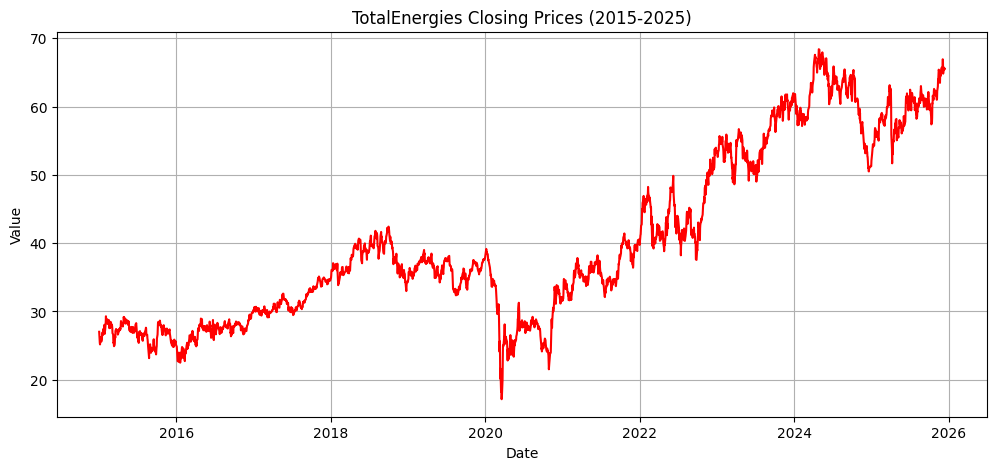

Price,Close
Ticker,TTE
count,2754.000000
mean,40.282160
std,12.600342
min,17.157007
25%,29.747591
50%,36.578976
75%,51.899840
max,68.392998


In [4]:
#Time Series plot

plt.figure(figsize=(12, 5))
plt.plot(tte.index, tte['Close'],  label='Total Energies Closing Price (EUR)', color='red')
plt.title("TotalEnergies Closing Prices (2015-2025)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

tte.describe()

The plot suggests evidence of volatility clustering: periods of high volatility tend to be followed by further high volatility, and low-volatility periods similarly persist. This suggests autocorrelation in volatility, i.e., conditional volatility.

# 2. EXPLOTARY DATA ANALYSIS

We proceed by calculating the log returns of TotalEnergies’ stock and evaluating their behavioral patterns and statistical features.

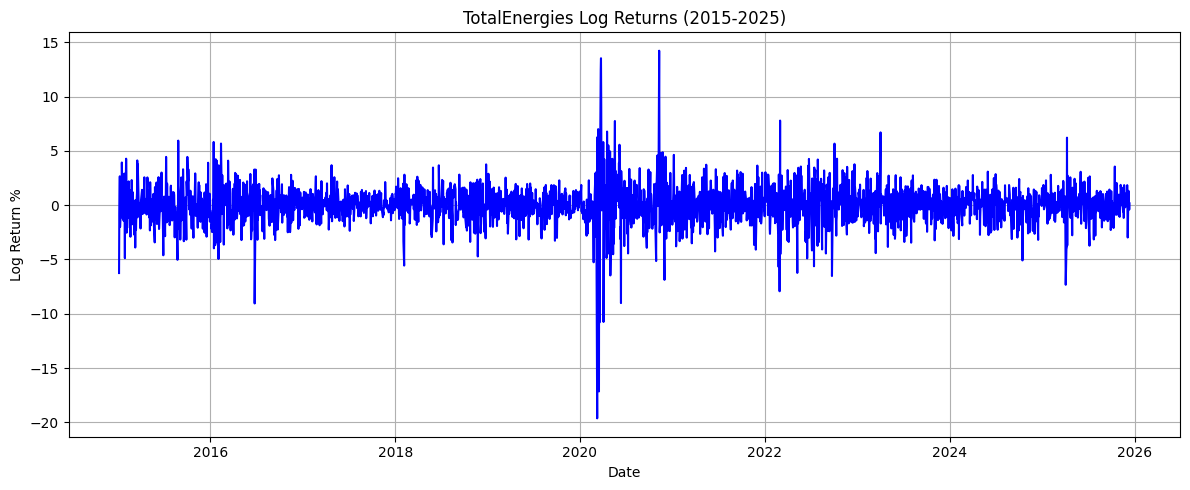

,Log Returns
count,2753.000000
mean,0.032163
std,1.823602
min,-19.626862
25%,-0.865800
50%,0.087400
75%,0.953170
max,14.215558


In [5]:
import numpy as np

# Compute log-returns
tte['Log Returns'] = np.log(tte['Close'] / tte['Close'].shift(1))*100

# Drop NaN values before plotting
tte = tte.dropna()

# Ensure enough data for ACF lags
max_lags = min(50, len(tte)-1)  # Limit lags if data is too short

# Plot log-returns alongside ACF
fig, axes = plt.subplots(figsize=(12, 5))

# Log-Returns Plot
axes.plot(tte.index, tte['Log Returns'], label='Total Energies Log Returns', color='blue')
axes.set_title("TotalEnergies Log Returns (2015-2025)")
axes.set_xlabel("Date")
axes.set_ylabel("Log Return %")
axes.grid()

plt.tight_layout()
plt.show()

tte['Log Returns'].describe()

The plot confirms the presence of volatility clustering and provides an indication of which type of model may be appropriate for forecasting the volatility of TotalEnergies’ stock.

We plot the LOESS curve and the rolling standard deviation to visualize how volatility evolves over time and to motivate the potential use of an ARCH/GARCH model.

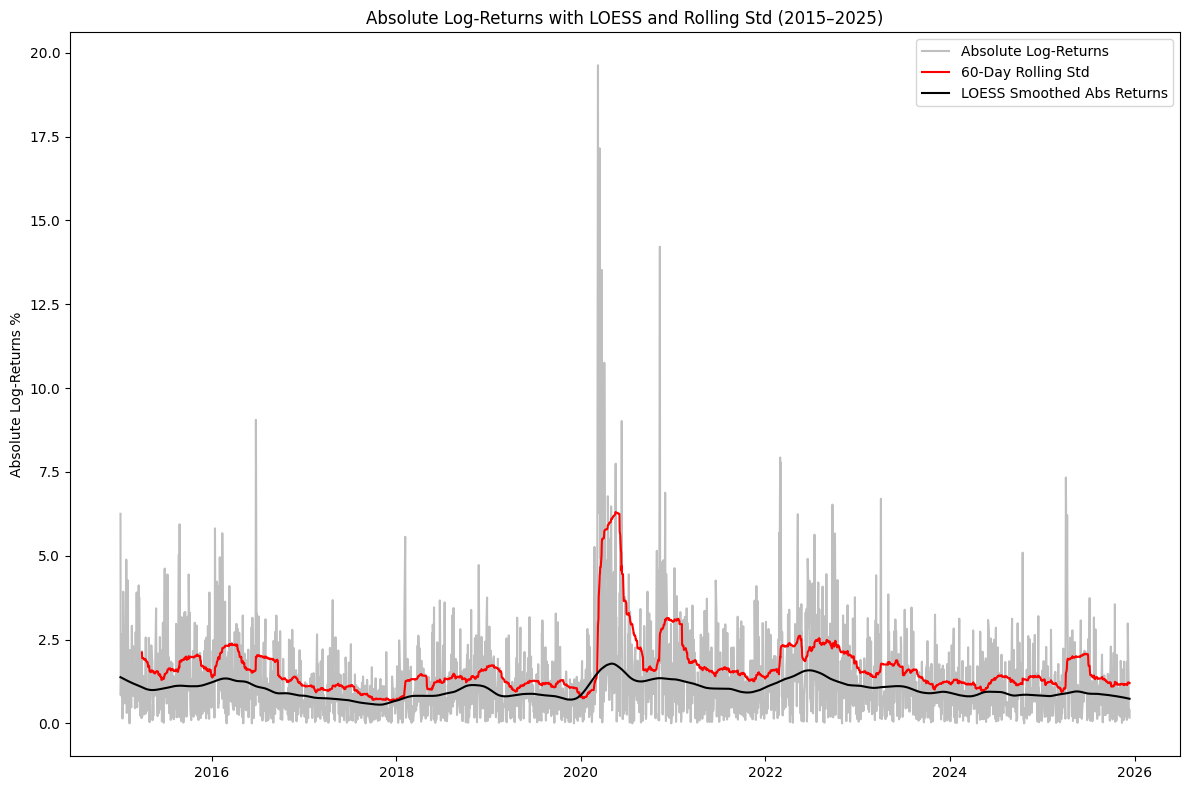

In [6]:
import statsmodels.api as sm

# Compute absolute log-returns
tte['Abs_Log_Return'] = np.abs(tte['Log Returns'])

# Compute rolling 60-day standard deviation
tte['Rolling_Std'] = tte['Log Returns'].rolling(window=60).std()

# LOESS smoothing (LOWESS from statsmodels)
lowess = sm.nonparametric.lowess
smoothed_abs = lowess(tte['Abs_Log_Return'], tte.index, frac=0.05)

# ---- Single Plot ----
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(tte.index, tte['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
ax.plot(tte.index, tte['Rolling_Std'], color='red', label='60-Day Rolling Std')
ax.plot(tte.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')

ax.set_ylabel("Absolute Log-Returns %")
ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2015–2025)")
ax.legend()

plt.tight_layout()
plt.show()

# DISTRIBUTION ANALYSIS OF LOG-RETURNS

We begin by fitting a normal distribution to our log returns and computing key descriptive statistics, including skewness, kurtosis, and a normality test.

Mean: 0.0322
Variance: 3.3243
Skewness: -0.8453
Kurtosis: 15.4974
Normality Test p-value: 0.0000 (Not Normal)


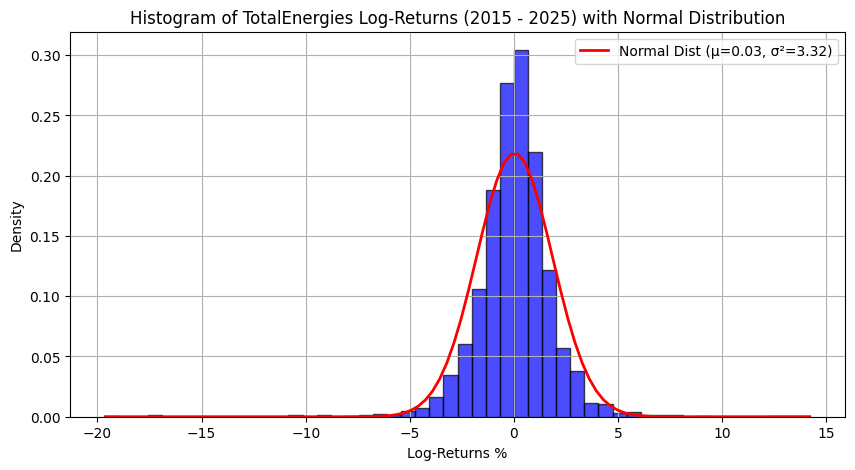

In [7]:
from scipy.stats import skew, kurtosis, normaltest, norm

# Compute statistics
mean_return = np.mean(tte['Log Returns'])
variance_return = np.var(tte['Log Returns'])
skewness_return = skew(tte['Log Returns'])
kurtosis_return = kurtosis(tte['Log Returns'])

# Normality test (D'Agostino and Pearson’s test)
stats_test, p_value = normaltest(tte['Log Returns'])
normality_result = "Normal" if p_value > 0.05 else "Not Normal"

# Print statistics
print(f"Mean: {mean_return:.4f}")
print(f"Variance: {variance_return:.4f}")
print(f"Skewness: {skewness_return:.4f}")
print(f"Kurtosis: {kurtosis_return:.4f}")
print(f"Normality Test p-value: {p_value:.4f} ({normality_result})")

# Plot histogram with overlaid normal distribution
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(tte['Log Returns'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

# Compute normal distribution curve
x = np.linspace(bins[0], bins[-1], 100)
pdf = norm.pdf(x, mean_return, np.sqrt(variance_return))
plt.plot(x, pdf, color='red', lw=2, label=f'Normal Dist (μ={mean_return:.2f}, σ²={variance_return:.2f})')

plt.xlabel("Log-Returns %")
plt.ylabel("Density")
plt.title("Histogram of TotalEnergies Log-Returns (2015 - 2025) with Normal Distribution")
plt.legend()
plt.grid()
plt.show()

We reject the hypothesis that the log returns follow a normal distribution. We therefore proceed to fit a t-distribution, which can better accommodate the heavier tails observed in the data.

Fitted t-distribution parameters:
Degrees of Freedom: 3.6848
Location: 0.0697
Scale: 1.2062
Variance: 3.1819
Kurtosis: Infinite


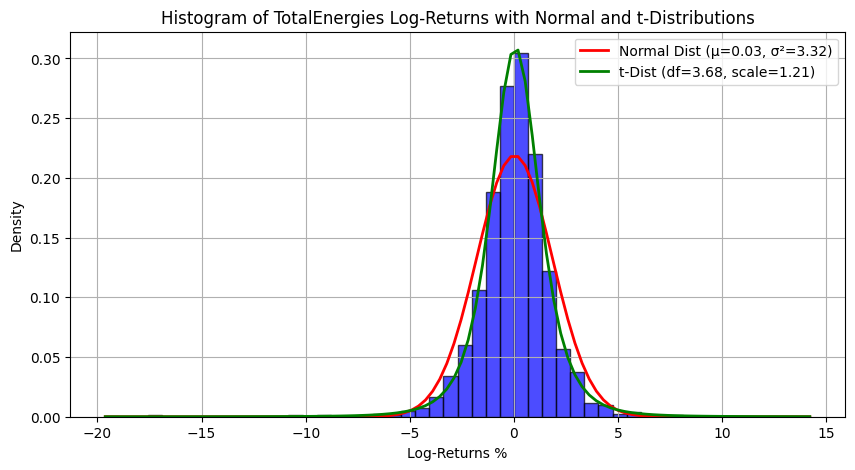

In [8]:
from scipy.stats import t

# Fit a t-distribution to the log-returns
params = t.fit(tte['Log Returns'])  # Direct fitting

# Extract fitted parameters
df_t, loc_t, scale_t = params

# Compute variance and kurtosis of the fitted t-distribution
variance_t = (df_t / (df_t - 2)) * (scale_t ** 2) if df_t > 2 else np.nan
kurtosis_t = (6 / (df_t - 4)) if df_t > 4 else np.inf  # Infinite for df <= 4

# Print fitted parameters and statistics
print(f"Fitted t-distribution parameters:")
print(f"Degrees of Freedom: {df_t:.4f}")
print(f"Location: {loc_t:.4f}")
print(f"Scale: {scale_t:.4f}")
print(f"Variance: {variance_t:.4f}")
print(f"Kurtosis: {'Infinite' if np.isinf(kurtosis_t) else f'{kurtosis_t:.4f}'}")

# Plot histogram with normal and t-distribution curves
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(tte['Log Returns'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

# Compute normal and t-distribution curves
x = np.linspace(bins[0], bins[-1], 100)
pdf_norm = norm.pdf(x, np.mean(tte['Log Returns']), np.std(tte['Log Returns']))
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

plt.plot(x, pdf_norm, color='red', lw=2, label=f'Normal Dist (μ={np.mean(tte["Log Returns"]):.2f}, σ²={np.var(tte["Log Returns"]):.2f})')
plt.plot(x, pdf_t, color='green', lw=2, label=f't-Dist (df={df_t:.2f}, scale={scale_t:.2f})')

plt.xlabel("Log-Returns %")
plt.ylabel("Density")
plt.title("Histogram of TotalEnergies Log-Returns with Normal and t-Distributions")
plt.legend()
plt.grid()
plt.show()

# AUTOCORRELATION ANALYSIS

To better understand the autocorrelation structure of our log returns, we compute both the ACF and PACF.

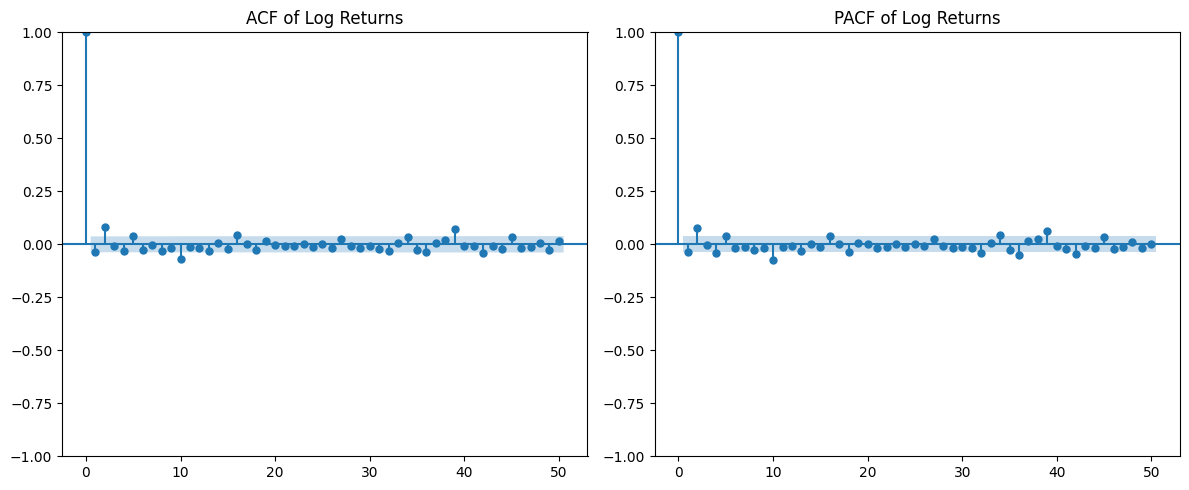

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(tte['Log Returns'], lags=50, ax=axes[0])
axes[0].set_title("ACF of Log Returns")

# PACF plot
plot_pacf(tte['Log Returns'], lags=50, ax=axes[1])
axes[1].set_title("PACF of Log Returns")

plt.tight_layout()
plt.show()

The ACF and PACF plots of log returns show that the returns exhibit no significant autocorrelation, meaning they behave like white noise and are not linearly predictable.

# 3. VOLATITLITY MODELLING

In this section, we estimate several volatility models fitted on the daily log returns of TTE in order to analyze the dynamics of return variability and to potentially forecast the stock’s volatility.

The model with the lowest AIC and BIC values is regarded as the best-fitting specification and will therefore be selected as the preferred model for the rest of the analysis.

# ARCH(2,8) MODEL


AR(2) + ARCH(8) Model Summary:
                              AR - ARCH Model Results                               
Dep. Variable:                  Log Returns   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.001
Vol Model:                             ARCH   Log-Likelihood:               -5031.16
Distribution:      Standardized Student's t   AIC:                           10088.3
Method:                  Maximum Likelihood   BIC:                           10165.3
                                              No. Observations:                 2751
Date:                      Fri, Dec 12 2025   Df Residuals:                     2748
Time:                              15:33:00   Df Model:                            3
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------

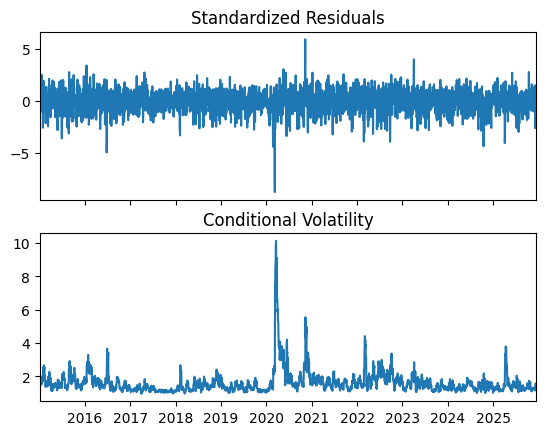

In [10]:
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data (you already have this)
returns = tte['Log Returns'].dropna()

# AR(2) + ARCH(10) with t-distributed errors
arch_spec = arch_model(
    returns,
    mean='AR',    # AR mean
    lags=2,       # AR(2)
    vol='ARCH',   # ARCH volatility
    p=8,         # ARCH(8)
    dist='t'      # t-distributed errors (same as your GARCH spec)
)

arch_fit = arch_spec.fit(disp='off')
print("\nAR(2) + ARCH(8) Model Summary:")
print(arch_fit.summary())

# Plot ARCH model results
fig = arch_fit.plot()
plt.show()

For the ARCH model, we iterated over values of p from 5 to 20 and obtained the best BIC at p = 8, with the following results:

Log-Likelihood:               -5024.75

AIC:                           10075.5

BIC:                           10152.4

# GARCH (1,1) MODEL


Model Summary:
                              AR - GARCH Model Results                              
Dep. Variable:                  Log Returns   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5020.10
Distribution:      Standardized Student's t   AIC:                           10052.2
Method:                  Maximum Likelihood   BIC:                           10087.7
                                              No. Observations:                 2752
Date:                      Fri, Dec 12 2025   Df Residuals:                     2750
Time:                              15:33:01   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------

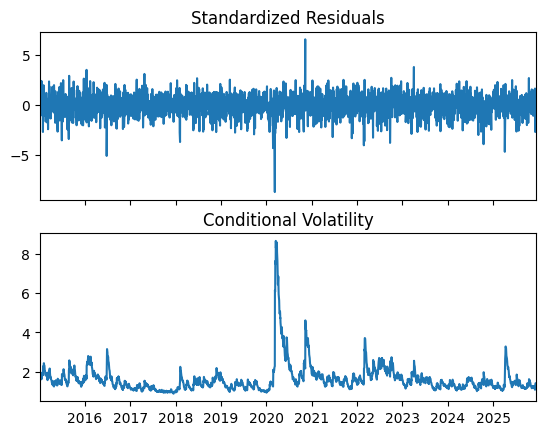

In [11]:

from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA

# Prepare the data
returns = tte['Log Returns'].dropna()

# Fit GARCH(1,1) model with t-distributed errors
garch_model = arch_model(returns, mean = 'AR', lags= 1, vol='Garch', p=1, o=0, q=1, dist='t')
garch_fit = garch_model.fit(disp='off')
print("\nModel Summary:")
print(garch_fit.summary())

# Plot GJR-GARCH model results
fig = garch_fit.plot()
plt.show()

For the GARCH model, we tested various combinations of p and q. The best specification was obtained with p = 1 and q = 1, with the corresponding results shown below:

Log-Likelihood: -5013.96

AIC:                           10039.9

BIC:                           10075.4

# GJR - GARCH MODEL (1,1,1)


AR(1) + GJR-GARCH(1,1,1) Model Summary:
                            AR - GJR-GARCH Model Results                            
Dep. Variable:                  Log Returns   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5011.70
Distribution:      Standardized Student's t   AIC:                           10037.4
Method:                  Maximum Likelihood   BIC:                           10078.8
                                              No. Observations:                 2752
Date:                      Fri, Dec 12 2025   Df Residuals:                     2750
Time:                              15:33:02   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------

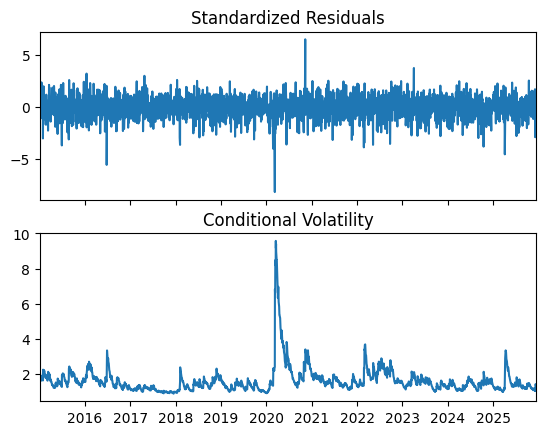

In [12]:
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data
returns = tte['Log Returns'].dropna()

# AR(1) + GJR-GARCH(1,1,1) with t-distributed errors
gjr_model = arch_model(
    returns,
    mean='AR',     # AR mean equation
    lags=1,        # AR(1)
    vol='Garch',   # GARCH-type volatility
    p=1,           # ARCH term (a_{t-1}^2)
    o=1,           # Asymmetric term (GJR; a_{t-1}^2 * I[a_{t-1}<0])
    q=1,           # GARCH term (sigma_{t-1}^2)
    dist='t'       # t-distributed innovations
)

gjr_fit = gjr_model.fit(disp='off')

print("\nAR(1) + GJR-GARCH(1,1,1) Model Summary:")
print(gjr_fit.summary())

# Plot GJR-GARCH model results
fig = gjr_fit.plot()
plt.show()

For the GJR - GARCH Model, we use p=1, o=1, q=1 and got the following results:

Log-Likelihood:               -5005.53

AIC:                           10025.1

BIC:                           10066.5



# EGARCH MODEL (1,1,1)


AR(1) + EGARCH(1,1) Model Summary:
                             AR - EGARCH Model Results                              
Dep. Variable:                  Log Returns   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5010.06
Distribution:      Standardized Student's t   AIC:                           10034.1
Method:                  Maximum Likelihood   BIC:                           10075.6
                                              No. Observations:                 2752
Date:                      Fri, Dec 12 2025   Df Residuals:                     2750
Time:                              15:33:03   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------

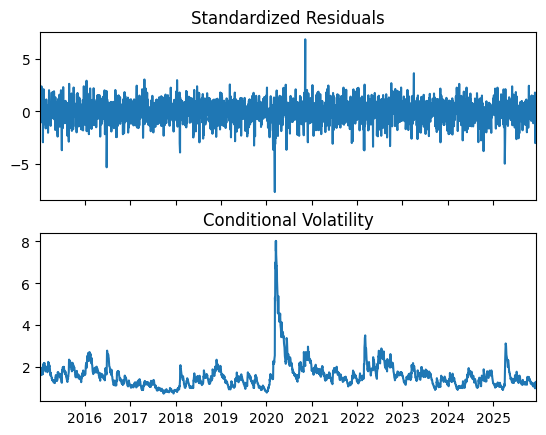

In [13]:
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data
returns = tte['Log Returns'].dropna()

# AR(1) + EGARCH(1,1) with t-distributed errors
egarch_model = arch_model(
    returns,
    mean='AR',      # AR mean equation
    lags=1,         # AR(1)
    vol='EGARCH',   # EGARCH volatility model
    p=1,            # ARCH term
    o=1,            # Asymmetry / leverage term
    q=1,            # GARCH term
    dist='t'        # t-distributed errors
)

egarch_fit = egarch_model.fit(disp='off')

print("\nAR(1) + EGARCH(1,1) Model Summary:")
print(egarch_fit.summary())

# Plot EGARCH model results
fig = egarch_fit.plot()
plt.show()

For the EGARCH Model (models log-variance), we use p=1, o=1, q=1 and got the following results:

Log-Likelihood: -5004.18

AIC:                           10022.4

BIC:                           10063.8

# CONCLUSION ON THE BEST-FITTING MODEL

After estimating the ARCH, GARCH, GJR-GARCH, and EGARCH models and comparing their log-likelihood, AIC, and BIC values, we conclude that the EGARCH specification provides the best fit for the volatility dynamics of TotalEnergies’ log returns.

Consequently, all subsequent analysis and visualizations are based on the EGARCH model.

# VISUALIZING VOLATILITY

The following code creates two plots that are commonly created in finance to visualize the volatility of financial data.

  1. The log-return series with a ribbon of +/- 2 standard deviations (dynamic) (alpha = 0.8)

  2. The absolute log-returns with the standard deviation (dynamic) (alpha = 0.8)

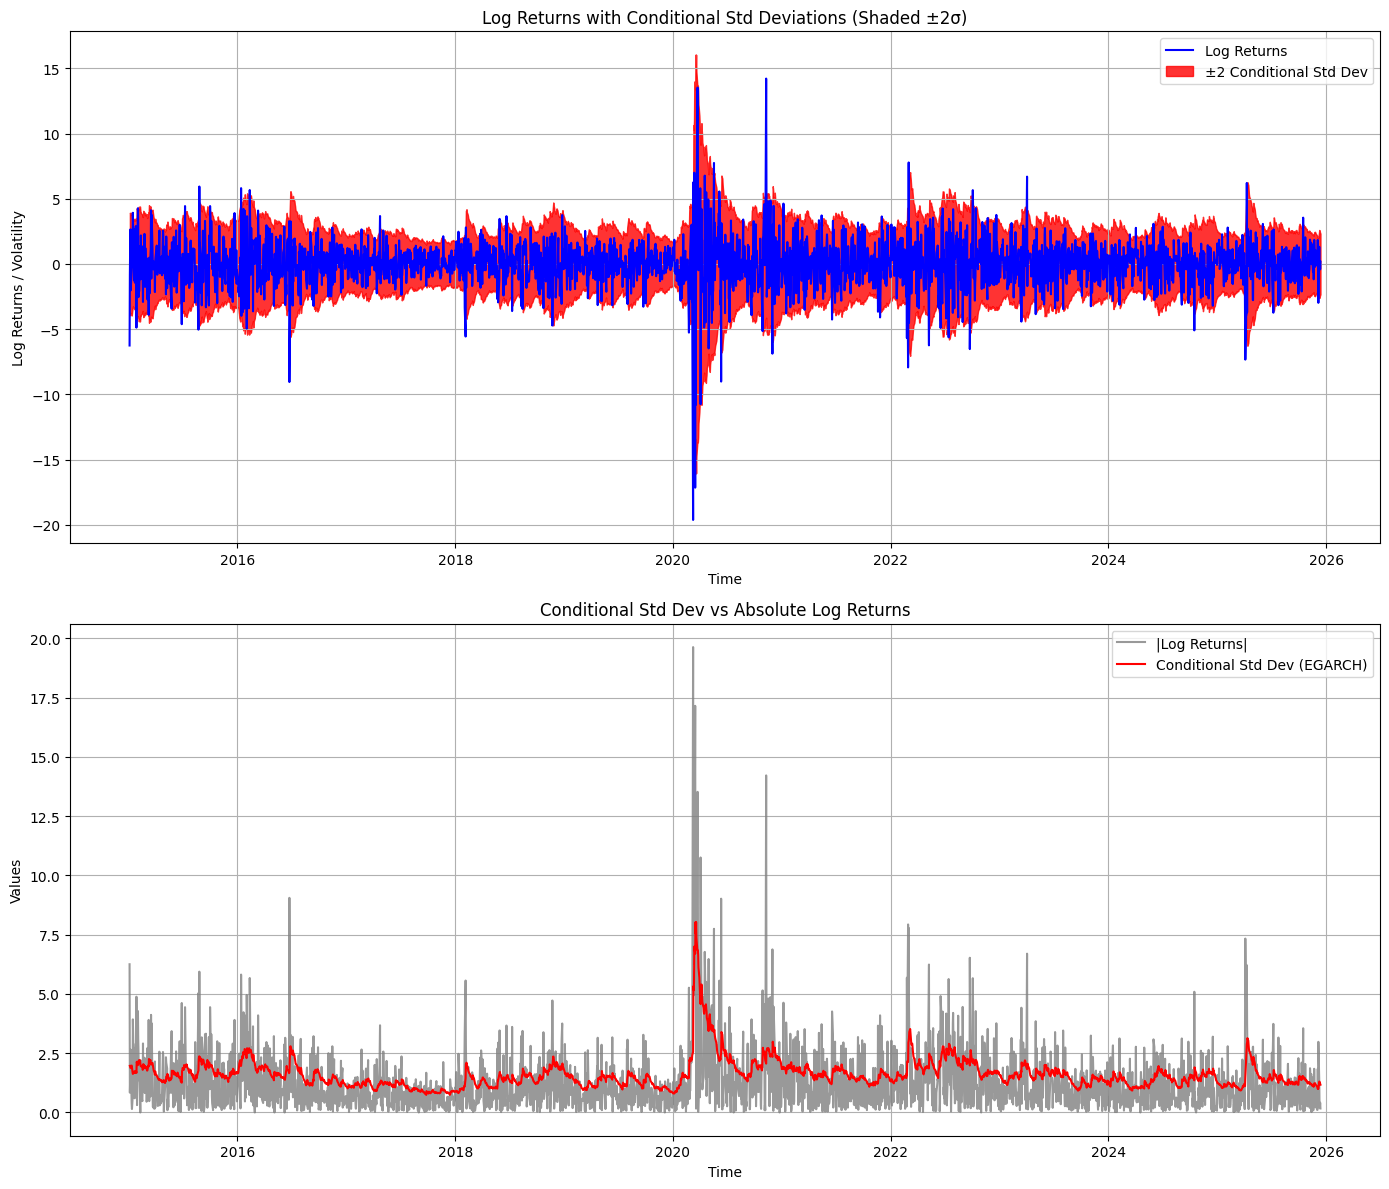

In [14]:
# Get the conditional volatility (sigma_t) and standardized residuals
conditional_volatility = egarch_fit.conditional_volatility
absolute_log_returns = np.abs(returns)

# Combined plot with two subplots stacked vertically
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Log returns with shaded ±2 conditional standard deviations
axs[0].plot(returns, label='Log Returns', color='blue')
upper_bound = 2 * conditional_volatility
lower_bound = -2 * conditional_volatility
axs[0].fill_between(tte.index, lower_bound, upper_bound, color='red', alpha=0.8, label='±2 Conditional Std Dev')
axs[0].set_title('Log Returns with Conditional Std Deviations (Shaded ±2σ)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Log Returns / Volatility')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Conditional Std Dev vs. Absolute Log Returns
axs[1].plot(absolute_log_returns, label='|Log Returns|', color='gray', alpha=0.8)
axs[1].plot(conditional_volatility, label='Conditional Std Dev (EGARCH)', color='red')
axs[1].set_title('Conditional Std Dev vs Absolute Log Returns')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.show()

# RESIDUAL ANALYSIS

Is the model appropriate for the data?
The following code generates the diagnostic visualizations to identify any remaining patterns not captured by the model. These plots help us assess whether the EGARCH specification is adequate and whether any important dynamics may have been omitted.

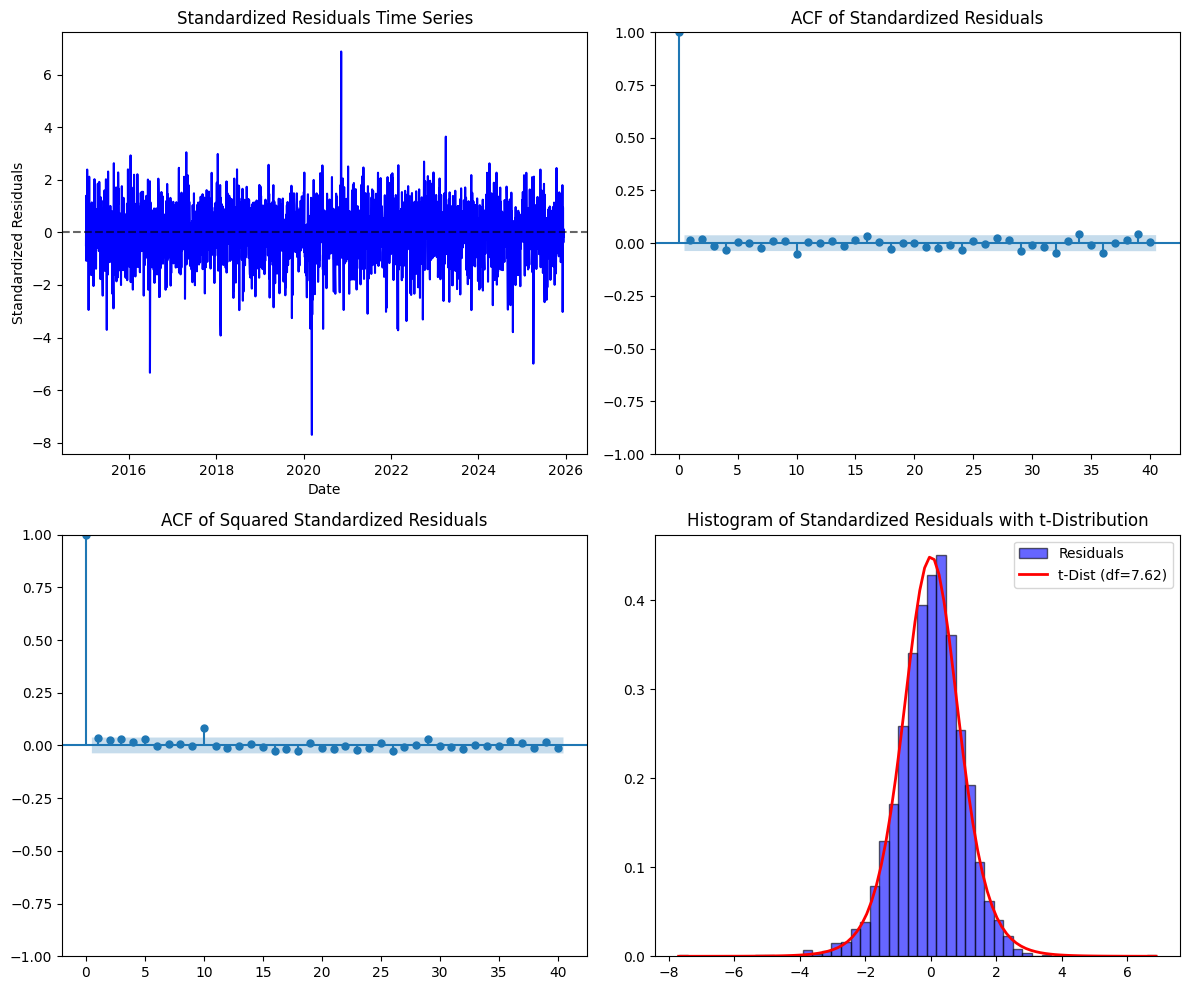

In [15]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t, probplot

# Compute standardized residuals
std_residuals = egarch_fit.resid / egarch_fit.conditional_volatility
std_residuals = std_residuals.dropna()

# Set up 2x2 residual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Standardized residual time series
sns.lineplot(x=std_residuals.index, y=std_residuals, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Standardized Residuals Time Series")
axes[0, 0].set_ylabel("Standardized Residuals")
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.6)

# 2. ACF of standardized residuals
plot_acf(std_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title("ACF of Standardized Residuals")

# 3. ACF of squared standardized residuals
plot_acf(std_residuals**2, ax=axes[1, 0], lags=40)
axes[1, 0].set_title("ACF of Squared Standardized Residuals")

# 4. QQ-plot with estimated t-distribution
df_t, loc_t, scale_t = t.fit(std_residuals)
x = np.linspace(min(std_residuals), max(std_residuals), 100)
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

axes[1, 1].hist(std_residuals, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black', label="Residuals")
axes[1, 1].plot(x, pdf_t, color='red', lw=2, label=f't-Dist (df={df_t:.2f})')
axes[1, 1].set_title("Histogram of Standardized Residuals with t-Distribution")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

From the four diagnostic plots, we conclude that the model does not omit any important factors. The standardized residuals behave like white noise—aside from the Covid period, which is reasonable for an energy company such as TotalEnergies—and only one significant ACF spike appears at lag 10 for the squared standardized residuals. This isolated spike can be regarded as an outlier that no model would reliably capture.

# 4. RISK MODELING

# VaR ESTIMATES

We're now going to analyze the Value-at-Risk of holding TotalEnergies stock to estimate the potential loss on an investment at a given confidence level.

The graph will include:

-   1. VaR for many possible levels (x-axis of the plot)
-   2. three different approaches - historical; Normal distribution; T-distribution
-  3. And plots the VaR (y-axis) of the three methods for different levels.

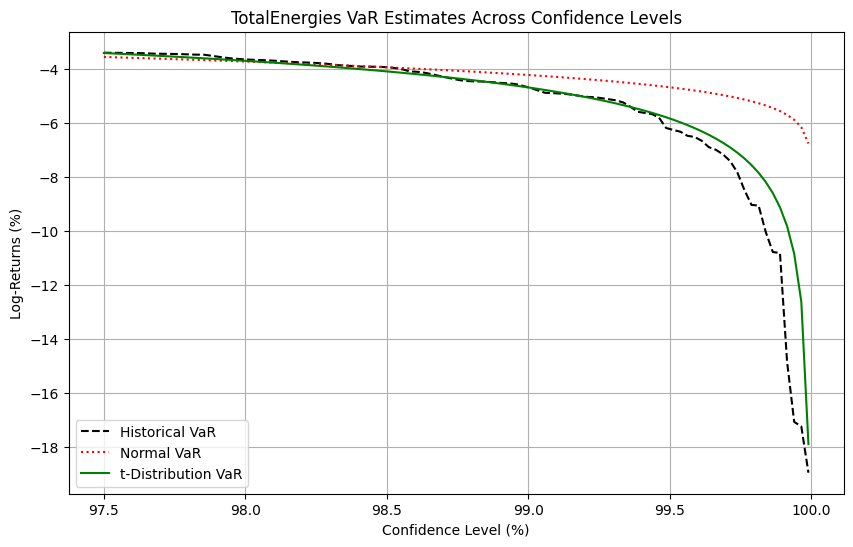

In [16]:
# Prepare the data
returns = tte['Log Returns'].dropna()

# Confidence levels for VaR
confidence_levels = np.linspace(0.975, 0.9999, 100)

# Compute VaR for different confidence levels
VaR_hist = [np.percentile(returns, (1 - alpha) * 100) for alpha in confidence_levels]
VaR_norm = [norm.ppf(1 - alpha, loc=np.mean(returns), scale=np.std(returns)) for alpha in confidence_levels]
df_t, loc_t, scale_t = t.fit(returns)
VaR_t = [loc_t + scale_t * t.ppf(1 - alpha, df_t) for alpha in confidence_levels]

# Plot VaR estimates as a function of confidence level
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels * 100, VaR_hist, label='Historical VaR', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, VaR_norm, label='Normal VaR', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, VaR_t, label='t-Distribution VaR', linestyle='solid', color='green')

plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Returns (%)")
plt.title("TotalEnergies VaR Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()

The historical VaR curve (black dashed line) shows a clear pattern of increasingly severe losses as the confidence level rises, though closely following the t-distribution.

At a confidence level around 97.5%, the historical VaR is relatively mild, with log-return losses of roughly 3,5%, indicating the magnitude of losses observed in moderately extreme market conditions.

As the confidence level increases to 99%, focusing on the worst 1% of return outcomes for TTE, the VaR decreases further to approximately –4.5% to –5%, indicating that extreme downside events, while rare, are associated with substantially larger losses.

Beyond 99.5%, the historical VaR drops sharply, reaching values near –10% to –12%, and continues falling as it approaches the 100% confidence limit, where losses exceed –15% to –18%.

This steep and irregular decline—visible as abrupt downward jumps—captures the impact of a small number of extreme crash days in the dataset. Overall, the historical VaR highlights the heavy-tailed nature of TotalEnergies returns and the presence of severe downside tail events not captured by the Normally-distributed VaR model.

# RISK MANAGEMENT - EXPECTED SHORTFALL (ES)

Expected Shortfall (ES), also known as Conditional VaR, measures the average loss an investor would experience in the worst α% of outcomes. In other words, The expected (average) loss given that the loss has already exceeded the VaR threshold.


Unlike VaR, which only identifies a threshold loss at a given confidence level, ES captures the severity of losses beyond that threshold. In the context of TotalEnergies stock, ES provides a more comprehensive assessment of downside risk, especially during periods of heightened commodity price volatility or geopolitical stress.

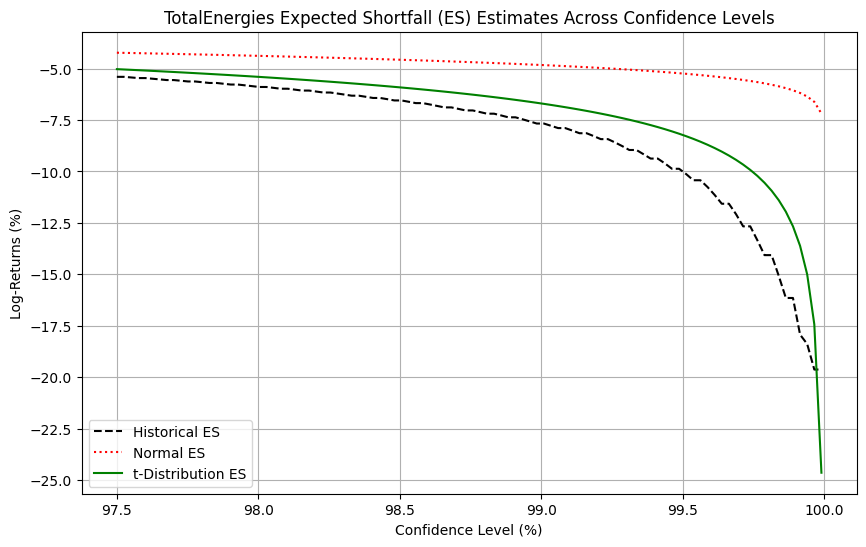

In [17]:
# Compute Expected Shortfall (ES) using the proper formulas
mean_return, std_return = returns.mean(), returns.std()
phi_norm = norm.pdf(norm.ppf(confidence_levels))
ES_norm = mean_return - std_return * (phi_norm / (1 - confidence_levels))

# Compute t-Distribution Expected Shortfall
t_alpha = t.ppf(confidence_levels, df_t)
t_pdf_alpha = t.pdf(t_alpha, df_t)
ES_t = loc_t - scale_t * (t_pdf_alpha / (1 - confidence_levels)) * (df_t + t_alpha**2) / (df_t - 1)

# Compute Historical Expected Shortfall (ES) directly from data
ES_hist = [returns[returns <= VaR_hist[i]].mean() for i in range(len(confidence_levels))]

# Plot Expected Shortfall (ES) estimates as a function of confidence level
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels * 100, ES_hist, label='Historical ES', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, ES_norm, label='Normal ES', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, ES_t, label='t-Distribution ES', linestyle='solid', color='green')
plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Returns (%)")
plt.title("TotalEnergies Expected Shortfall (ES) Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()

The historical ES curve indicates increasingly severe expected losses as the confidence level rises, while the ES computed under the t-distribution remains consistently higher than the historical ES. This is consistent with our earlier VaR results, since ES reflects the average magnitude of losses beyond the VaR threshold and therefore captures tail risk more strongly under a heavy-tailed distribution.

At 97.5%–98%, ES is around –5% to –6%, reflecting losses during moderately extreme downturns. By 99%, ES deepens to –7,5%, capturing the worst 1% of days. Beyond 99.5%, ES drops sharply to –15% to –20%, indicating the impact of rare but severe crash events driven by oil price shocks, geopolitical tensions, or market stress.

#5. DYNAMIC RISK MODELING

In the final part of the analysis, we compute dynamic VaR estimates for the historical data using the EGARCH model. The figure below displays the resulting 95% and 99% dynamic VaR measures fitted to the log returns of TotalEnergies’ stock.

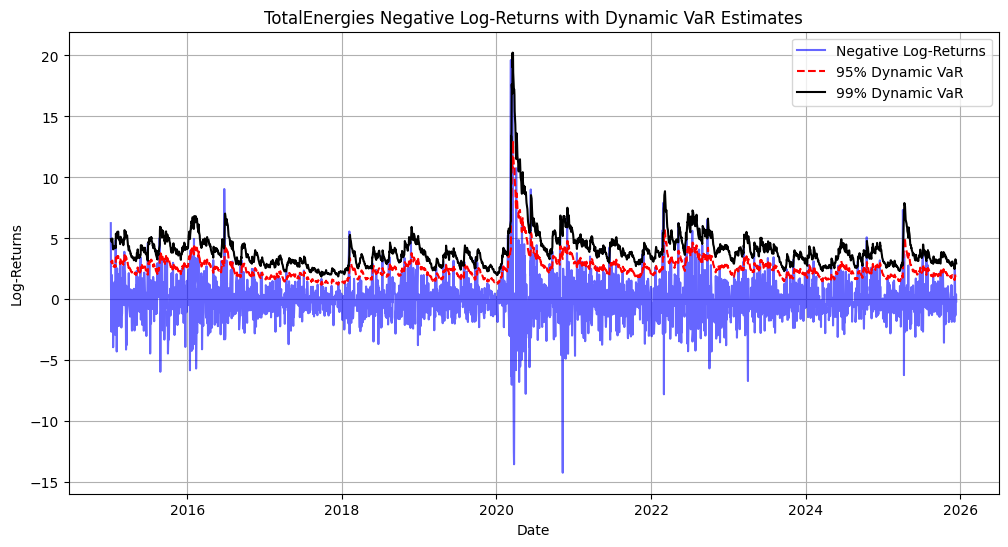

In [18]:
# Extract conditional volatility and standardized residuals
std_residuals = egarch_fit.resid / egarch_fit.conditional_volatility
std_residuals = std_residuals.dropna()
cond_volatility = egarch_fit.conditional_volatility.dropna()

# Fit t-distribution to standardized residuals
df_t, loc_t, scale_t = t.fit(std_residuals)

# Compute dynamic VaR at 95% and 99%
VaR_95 = -scale_t * t.ppf(0.05, df_t) * cond_volatility
VaR_99 = -scale_t * t.ppf(0.01, df_t) * cond_volatility

# Plot time series of negative log-returns with dynamic VaR
plt.figure(figsize=(12, 6))
plt.plot(-returns, label="Negative Log-Returns", color='blue', alpha=0.6)
plt.plot(VaR_95, label="95% Dynamic VaR", linestyle='dashed', color='red')
plt.plot(VaR_99, label="99% Dynamic VaR", linestyle='solid', color='black')

plt.xlabel("Date")
plt.ylabel("Log-Returns")
plt.title("TotalEnergies Negative Log-Returns with Dynamic VaR Estimates")
plt.legend()
plt.grid()
plt.show()

The graph shows that the 99% dynamic VaR is consistently higher than the 95% VaR, which is expected since higher confidence levels produce more conservative risk estimates. Both curves rise sharply during the early 2020 period, reflecting the extreme volatility observed during the COVID-19 pandemic.

# BACKTESTING THE MODEL

The following graph identifies the points in time at which the 95% and 99% dynamic VaR levels were actually violated.

It also reports summary statistics comparing the observed number of violations with the model-implied expectations, allowing us to assess the model’s performance and its adequacy when applied to real data.

Total observations used for VaR backtest: 2752
95% VaR violations: 140 (5.09% of days)
99% VaR violations: 35 (1.27% of days)
Expected 95% violations ≈ 137.6
Expected 99% violations ≈ 27.5


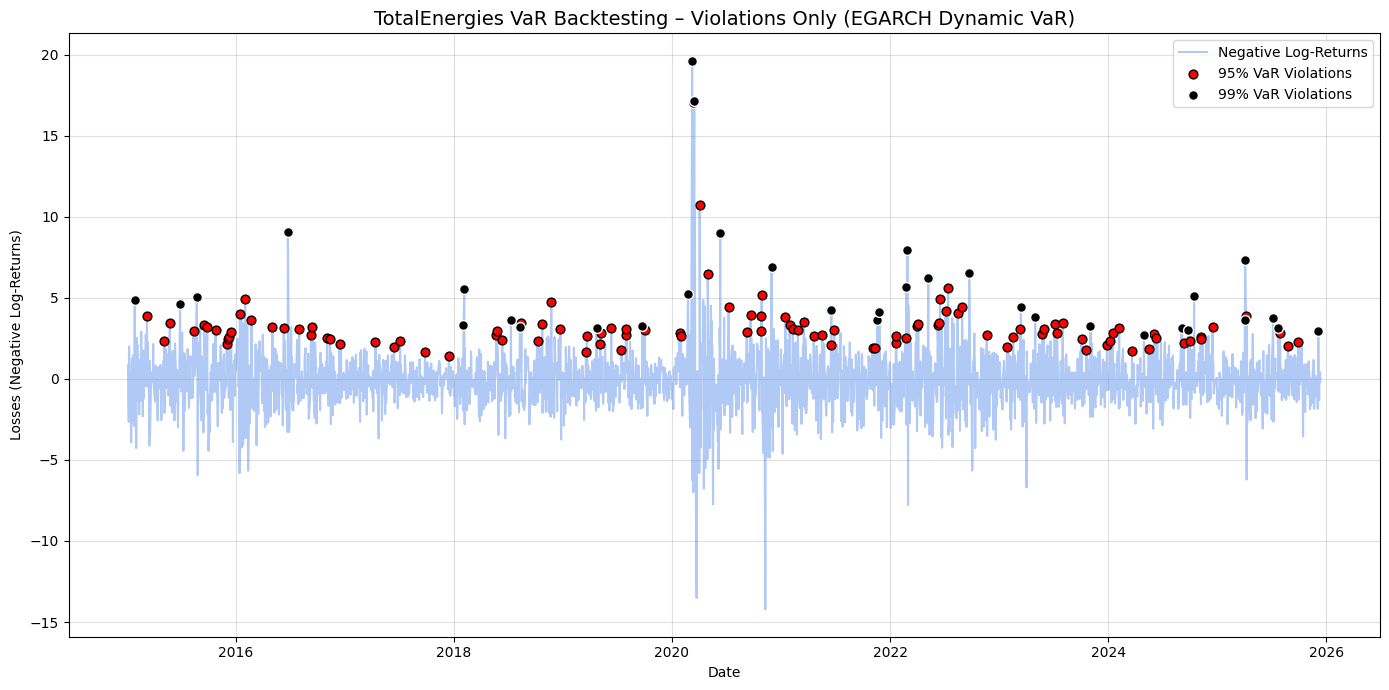

In [19]:
# Make sure everything is aligned
backtest_df = pd.DataFrame({
    "returns": returns,
    "VaR_95": VaR_95,
    "VaR_99": VaR_99
}).dropna()

# Losses are negative returns (positive number = loss)
losses = -backtest_df["returns"]

# VaR violations: actual loss > VaR threshold
viol_95 = losses > backtest_df["VaR_95"]
viol_99 = losses > backtest_df["VaR_99"]

n_obs = len(backtest_df)
n_viol_95 = viol_95.sum()
n_viol_99 = viol_99.sum()

pct_viol_95 = 100 * n_viol_95 / n_obs
pct_viol_99 = 100 * n_viol_99 / n_obs

print(f"Total observations used for VaR backtest: {n_obs}")
print(f"95% VaR violations: {n_viol_95} ({pct_viol_95:.2f}% of days)")
print(f"99% VaR violations: {n_viol_99} ({pct_viol_99:.2f}% of days)")

# Optional: expected violations under correct model
print(f"Expected 95% violations ≈ {0.05*n_obs:.1f}")
print(f"Expected 99% violations ≈ {0.01*n_obs:.1f}")


# Prepare aligned DataFrame
backtest_df = pd.DataFrame({
    "returns": returns,
    "VaR_95": VaR_95,
    "VaR_99": VaR_99
}).dropna()

losses = -backtest_df["returns"]

# Identify violations
viol_95 = losses > backtest_df["VaR_95"]
viol_99 = losses > backtest_df["VaR_99"]

# Plot
plt.figure(figsize=(14, 7))

# Plot negative log-returns (losses)
plt.plot(losses.index, losses, color='cornflowerblue', alpha=0.5, label="Negative Log-Returns")

# Plot ONLY violation points (no VaR lines)
plt.scatter(
    losses.index[viol_95], losses[viol_95],
    color='red', edgecolors='black', s=40, zorder=5,
    label="95% VaR Violations"
)

plt.scatter(
    losses.index[viol_99], losses[viol_99],
    color='black', edgecolors='white', s=50, zorder=6,
    label="99% VaR Violations"
)

# Labels
plt.title("TotalEnergies VaR Backtesting – Violations Only (EGARCH Dynamic VaR)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Losses (Negative Log-Returns)")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()

plt.show()



To begin, we interpret the summary statistics of the VaR violations and how they link to our analysis. We know that the dataset includes 2752 observations (TTE closing prices). When fitting the EGARCH Dynamic VaR model on this data, we expect VaR violations to happen 137.6 times (5% of observations) for our 95% dynamic VaR, and 27.5 times (1% of observations) for our 99% dynamic VaR. the actual results are close, with the 95% VaR being violated 140 times (5,09% of days) and the 99% VaR being violated 35 times (1,27% of days).

Hence we can conclude that our model is reasonably accurate, although it exhibits a slight tendency to underestimate tail risk.

Secondly, the visualization shows that VaR violations are distributed throughout the entire sample period, with the notable exception of 2017, during which no 99% VaR violations occurred.

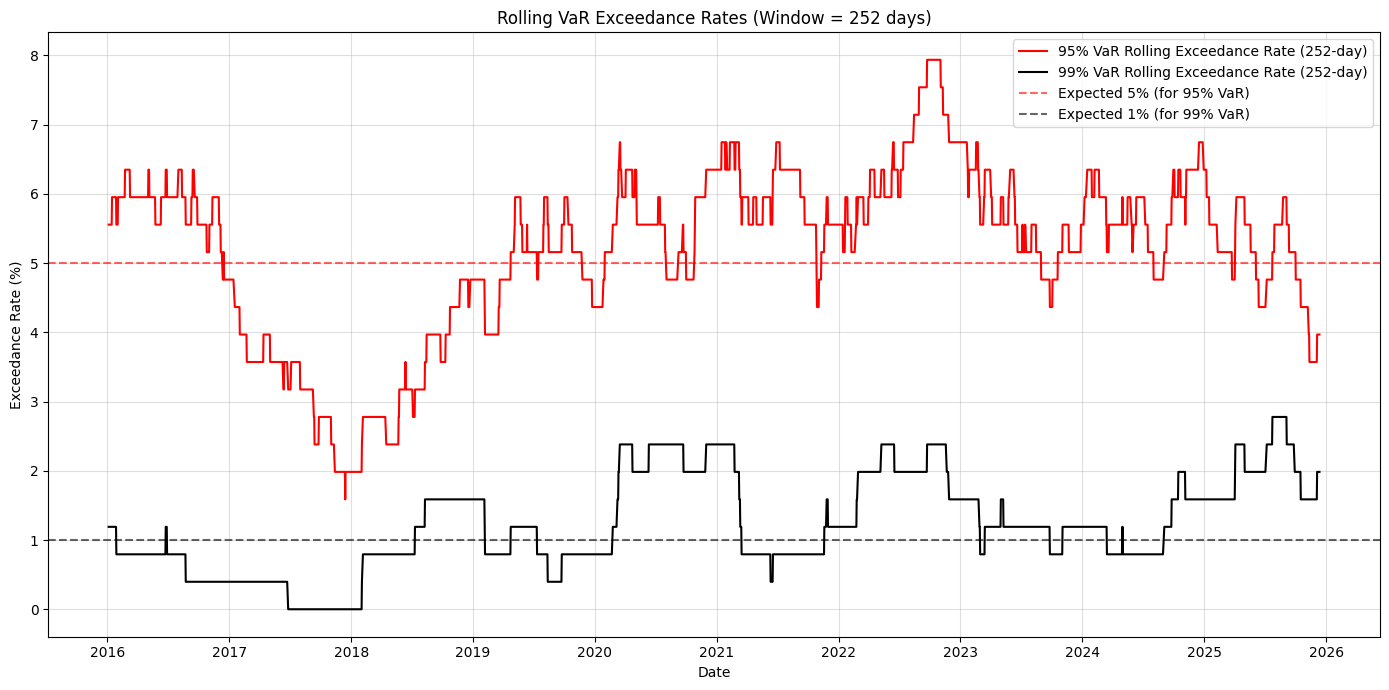

In [22]:
# --- Prepare data (same objects you already have) ---
backtest_df = pd.DataFrame({
    "returns": returns,
    "VaR_95": VaR_95,
    "VaR_99": VaR_99
}).dropna()

losses = -backtest_df["returns"]

# --- Identify violations (1 = violation, 0 = no violation) ---
viol_95 = (losses > backtest_df["VaR_95"]).astype(int)
viol_99 = (losses > backtest_df["VaR_99"]).astype(int)

# --- Rolling exceedance rate (use ~1 trading year, e.g. 252 days) ---
window = 252  # change if you prefer 125, 250, etc.

rolling_viol_95 = viol_95.rolling(window).mean() * 100  # in %
rolling_viol_99 = viol_99.rolling(window).mean() * 100  # in %

# Drop initial NaNs from rolling window
rolling_viol_95 = rolling_viol_95.dropna()
rolling_viol_99 = rolling_viol_99.dropna()

# --- Plot rolling exceedance rates ---
plt.figure(figsize=(14, 7))

plt.plot(rolling_viol_95.index, rolling_viol_95,
         label=f"95% VaR Rolling Exceedance Rate ({window}-day)", color="red")
plt.plot(rolling_viol_99.index, rolling_viol_99,
         label=f"99% VaR Rolling Exceedance Rate ({window}-day)", color="black")

# Expected theoretical rates
plt.axhline(5, color="red", linestyle="--", alpha=0.6, label="Expected 5% (for 95% VaR)")
plt.axhline(1, color="black", linestyle="--", alpha=0.6, label="Expected 1% (for 99% VaR)")

plt.title(f"Rolling VaR Exceedance Rates (Window = {window} days)")
plt.xlabel("Date")
plt.ylabel("Exceedance Rate (%)")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


The rolling VaR exceedance analysis shows that the 95% EGARCH–t VaR model is not perfectly calibrated, with exceedance rates frequently rising above the theoretical 5% threshold—reaching 6–8% during periods such as 2016, 2019–2021, and 2022–2024—indicating systematic underestimation of risk, while in calmer years like 2017–2018 the rate falls to 2-4%, meaning the model becomes overly conservative; overall, this reflects time-varying performance consistent with shifting volatility regimes.

In contrast, the 99% VaR model performs substantially better, maintaining exceedance rates close to the expected 1% (generally 0–1.5% and rarely above 2%), demonstrating strong calibration and aligning with Basel standards for acceptable tail-risk behavior. Structural breaks are also evident, with exceedances spiking noticeably during crisis periods such as 2019–2021—marked by COVID-19, oil price shocks, and broader macroeconomic instability—highlighting that even advanced GARCH models struggle to fully capture abrupt surges in volatility and tail risk.

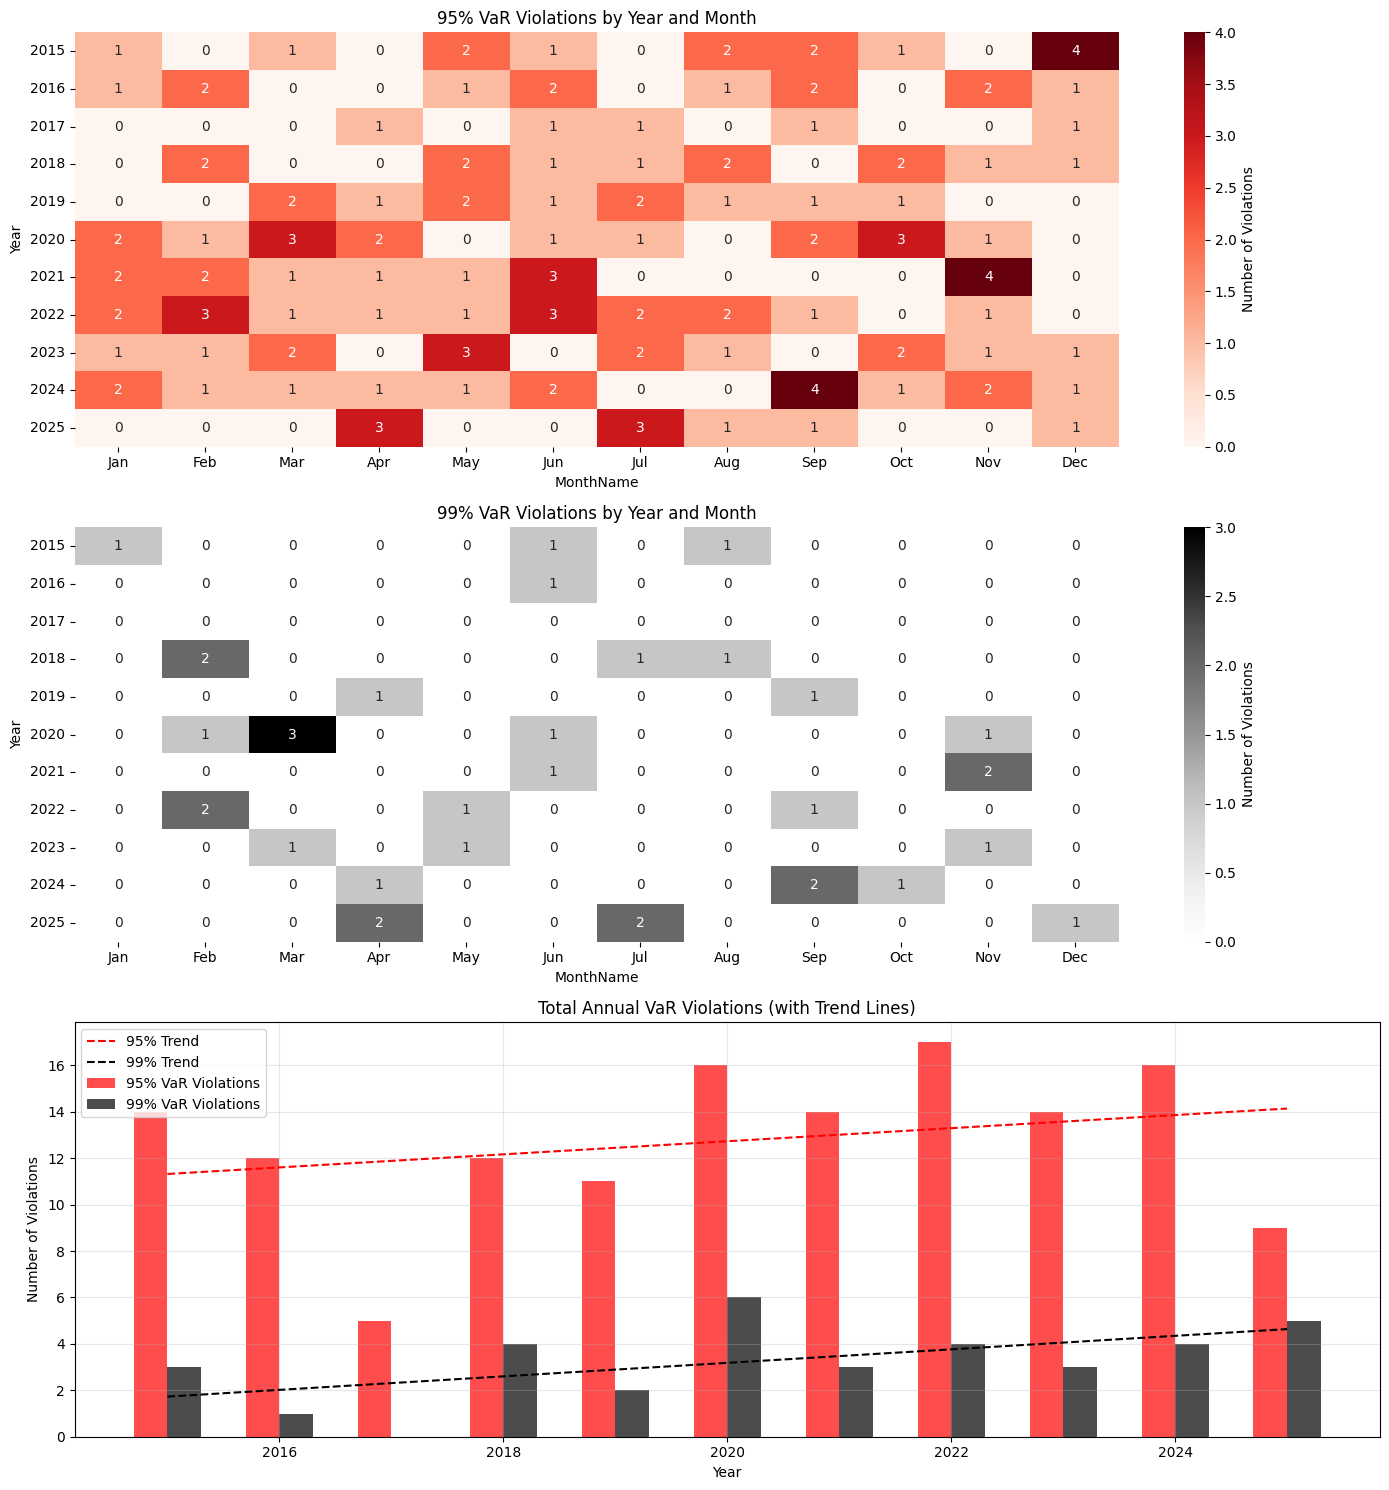

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# ----------------------------------------------------
# 1. Prepare backtesting DataFrame and violation flags
# ----------------------------------------------------
backtest_df = pd.DataFrame({
    "returns": returns,
    "VaR_95": VaR_95,
    "VaR_99": VaR_99
}).dropna()

losses = -backtest_df["returns"]

# 1 if loss > VaR, else 0
backtest_df["viol_95"] = (losses > backtest_df["VaR_95"]).astype(int)
backtest_df["viol_99"] = (losses > backtest_df["VaR_99"]).astype(int)

# Add year and month info
backtest_df["Year"] = backtest_df.index.year
backtest_df["Month"] = backtest_df.index.month
month_name_map = {i: calendar.month_abbr[i] for i in range(1, 13)}
backtest_df["MonthName"] = backtest_df["Month"].map(month_name_map)

# ----------------------------------------------------
# 2. Aggregate violations by Year–Month
# ----------------------------------------------------
viol_95_monthly = (
    backtest_df.groupby(["Year", "MonthName"])["viol_95"]
    .sum()
    .reset_index()
)

viol_99_monthly = (
    backtest_df.groupby(["Year", "MonthName"])["viol_99"]
    .sum()
    .reset_index()
)

month_order = [calendar.month_abbr[i] for i in range(1, 13)]

heat_95 = viol_95_monthly.pivot(index="Year", columns="MonthName", values="viol_95")[month_order]
heat_99 = viol_99_monthly.pivot(index="Year", columns="MonthName", values="viol_99")[month_order]

# ----------------------------------------------------
# 3. NEW: Total annual violations
# ----------------------------------------------------
yearly_viol_95 = backtest_df.groupby("Year")["viol_95"].sum()
yearly_viol_99 = backtest_df.groupby("Year")["viol_99"].sum()

# ----------------------------------------------------
# 4. Plot heatmaps
# ----------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# --- Heatmap 95% ---
sns.heatmap(
    heat_95, ax=axes[0], cmap="Reds", annot=True, fmt=".0f",
    cbar_kws={"label": "Number of Violations"}
)
axes[0].set_title("95% VaR Violations by Year and Month")
axes[0].set_ylabel("Year")

# --- Heatmap 99% ---
sns.heatmap(
    heat_99, ax=axes[1], cmap="Greys", annot=True, fmt=".0f",
    cbar_kws={"label": "Number of Violations"}
)
axes[1].set_title("99% VaR Violations by Year and Month")
axes[1].set_ylabel("Year")

# ----------------------------------------------------
# 5. Annual totals plotted with trend lines
# ----------------------------------------------------
axes[2].bar(yearly_viol_95.index - 0.15, yearly_viol_95.values, width=0.3,
            color="red", alpha=0.7, label="95% VaR Violations")
axes[2].bar(yearly_viol_99.index + 0.15, yearly_viol_99.values, width=0.3,
            color="black", alpha=0.7, label="99% VaR Violations")

# Trend lines (linear fit)
z95 = np.polyfit(yearly_viol_95.index, yearly_viol_95.values, 1)
trend95 = np.poly1d(z95)(yearly_viol_95.index)
axes[2].plot(yearly_viol_95.index, trend95, color="red", linestyle="--", label="95% Trend")

z99 = np.polyfit(yearly_viol_99.index, yearly_viol_99.values, 1)
trend99 = np.poly1d(z99)(yearly_viol_99.index)
axes[2].plot(yearly_viol_99.index, trend99, color="black", linestyle="--", label="99% Trend")

axes[2].set_title("Total Annual VaR Violations (with Trend Lines)")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Number of Violations")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In this final graph, the number of violations for both the 95% and 99% dynamic VaR levels is summarized in a histogram-style bar chart, accompanied by fitted trend lines to capture the evolution of violations over time. The upward trend observed in both series indicates that the model has increasingly underestimated risk as time progresses.

This trend could potentially be incorporated or further examined within an extended EGARCH framework in future analyses of TotalEnergies’ volatility dynamics.

# Conclusion and Financial Implications of the Risk Analysis

Our analysis of TotalEnergies’ daily log-returns from 2015 to 2025 confirms that the stock exhibits strong volatility clustering, fat tails, and departures from normality. Standard linear and homoskedastic models are therefore inadequate for capturing its risk profile. Among the specifications tested (ARCH, GARCH, GJR-GARCH, EGARCH), the EGARCH(1,1,1) with a Student-t distribution emerges as the best-fitting model in terms of log-likelihood and information criteria, while also aligning well with diagnostic checks. This model captures both the asymmetric response of volatility to negative shocks and the heavy-tailed nature of returns, both of which are crucial for risk management.

Using this volatility model, we compute Value-at-Risk (VaR) and Expected Shortfall (ES) with three approaches: historical simulation, normal distribution, and t-distribution. The comparison shows that normal-based VaR systematically understates downside risk, especially at higher confidence levels (e.g. 97.5–99%). Both the historical and t-distribution VaR curves indicate larger potential losses than the normal model for the same confidence level, reflecting the heavy tails observed in the data. The ES estimates reinforce this result: the Historical ES is notably more severe than the normal ES, and the t-ES again lies closer to the historical metric. In practical terms, this means that extreme losses in TotalEnergies’ equity occur more frequently and are more severe than what a Gaussian assumption would imply.




From a financial management perspective, this has several implications:

1. Capital and risk limits: If TotalEnergies’ market risk were managed or reported using normal VaR, the firm (and its regulators or creditors) would be underestimating the capital needed to absorb extreme market moves. Adopting t-based or historical VaR/ES as internal risk metrics would lead to higher, more conservative risk capital and more realistic risk limits, especially around known stress periods (e.g. oil price shocks, geopolitical events, or energy crises).

2. Cost of capital and leverage decisions: The heavier downside tail documented by our VaR/ES analysis implies a higher true equity risk than a normal model suggests. This can justify a higher equity risk premium demanded by investors, affecting the firm’s cost of capital. Management decisions on leverage, share buybacks, and payout policies should therefore be evaluated against state-dependent risk, recognizing that in high-volatility regimes the probability of large negative equity moves is materially higher.

3. Hedging and portfolio management: For both the firm’s treasury/risk team and external investors, the dynamic VaR analysis shows that risk is time-varying, spiking around turbulent periods. This supports a dynamic hedging and allocation policy: increasing hedging intensity (e.g. via options or futures) and reducing risk exposures when model-based VaR and ES rise, while allowing more risk capacity when volatility subsides. For diversified investors, the fat-tailed nature of TotalEnergies’ returns means the stock should be treated as a source of tail risk in portfolios, not as a stable “defensive” component despite its large-cap, integrated energy profile.

4. Performance measurement and incentives: Since downside risk is concentrated in specific high-volatility periods, using simple volatility or normal-based risk measures in performance evaluation may reward short-term risk-taking that loads on tail risk. Incorporating VaR/ES-based risk-adjusted metrics (e.g. returns per unit of ES) into managerial KPIs and bonus schemes would better align incentives with the true risk profile highlighted by our models.

Overall, the report shows that properly specified conditional volatility models and tail-sensitive risk measures are essential for TotalEnergies. Relying on normal-based assumptions would lead to systematic underestimation of extreme downside risk, potentially resulting in insufficient capital buffers, overly aggressive leverage, and mispriced equity. In contrast, using the EGARCH–t framework together with historical and t-based VaR/ES provides a more realistic view of the firm’s market risk and supports more prudent financial, hedging, and capital allocation decisions.